# Análisis Socioeconómico de la Región Metropolitana

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import statsmodels.api as sm
import os

## Lectura de archivos

In [ ]:
# codigos de cada comuna
codigos_comunales = pd.read_csv(
    os.path.join("data", "codigos_comunales.csv")
    )

# volvemos a la carpeta principal del proyecto
%cd ..

# data de tramos CSE para cada comuna desde 2016 a 2020
carpeta = "data/BIDAT-RSH/RSH 2016 - 2021/*.csv"
# diccionario que contendra los geodataframes de cada periodo
dict_mapas = {}
for ruta_archivo in glob.glob(carpeta):
    df = pd.read_csv(ruta_archivo)
    nombre_archivo = os.path.basename(ruta_archivo).split(".")[0]
    df.columns = [
    "codigo comuna",
    "hogares tramo 0 - 40",
    "hogares tramo 41 - 50",
    "hogares tramo 51 - 60",
    "hogares tramo 61 - 70",
    "hogares tramo 71 - 80",
    "hogares tramo 81 - 90",
    "hogares tramo 91 - 100",
    "total hogares"
]
    df = df.astype(int)
    df_final = pd.merge(df, codigos_comunales, how="right", on="codigo comuna")

    # df con porcentaje de población bajo tramo 40
    df_pobreza = df_final[
        ["codigo comuna", "nombre comuna", "hogares tramo 0 - 40"]
        ]
    df_pobreza["prc tramo 0 - 40"] = df_final["hogares tramo 0 - 40"] / df_final["total hogares"]
    df_pobreza.sort_values("prc tramo 0 - 40", inplace=True, ignore_index=True)

    # df con porcentaje de poblacion sobre tramo 70
    df_riqueza = df_final[
        ["codigo comuna", "nombre comuna", "hogares tramo 71 - 80", "hogares tramo 81 - 90", "hogares tramo 91 - 100"]
        ]
    df_riqueza["prc tramos altos"] = (df_final["hogares tramo 71 - 80"] + \
                                      df_final["hogares tramo 81 - 90"] + \
                                      df_final["hogares tramo 91 - 100"]) / df_final["total hogares"]
    df_riqueza.sort_values("prc tramos altos", inplace=True, ignore_index=True)

    # data anterior con informacion georreferenciada 
    mapa: gpd.GeoDataFrame = gpd.read_file(
        os.path.join("data", "r13.geojson")
        )
    mapa.drop("codigo_region", axis="columns", inplace=True)
    mapa["codigo_comuna"] = mapa["codigo_comuna"].astype(int)
    mapa["codigo_provincia"] = mapa["codigo_provincia"].astype(int)
    mapa = mapa.dissolve("codigo_comuna")
    mapa = pd.merge(mapa, df_pobreza[["codigo comuna", "prc tramo 0 - 40"]], 
                    how="left", left_index=True, right_on="codigo comuna")
    mapa = pd.merge(mapa, df_riqueza[["codigo comuna", "prc tramos altos", "nombre comuna"]], 
                    how="left", on="codigo comuna")

    dict_mapas[nombre_archivo.split("_")[3]] = mapa

# volvemos al a carpeta de este analisis
%cd analisisSocioEconomico

In [ ]:
# ejecutar para visualizar uno de los GeoDataFrame almacenados
# en el diccionario

dict_mapas["202006"]

## Mapas de calor tramos CSE

In [ ]:
# guardamos los periodos de data disponibles
lista_periodos = list(dict_mapas.keys())
lista_periodos.sort()

In [43]:
# funcion para graficar la data de los tramos CSE
def plot_mapa(dict_mapas, periodo, tramos, ax):
    if tramos == "bajos":
        columna_plot = "prc tramo 0 - 40"
        colores_plot = "Reds"
        ax.set_title(f"Porcentaje hogares tramo 0%-40% {periodo[4:]}/{periodo[0:4]}")
    elif tramos == "altos":
        columna_plot = "prc tramos altos"
        colores_plot = "Blues"
        ax.set_title(f"Porcentaje hogares tramo 70%-100% {periodo[4:]}/{periodo[0:4]}")
    dict_mapas[periodo].plot(
        column = columna_plot,
        cmap = colores_plot,
        legend = True,
        ax=ax,
        vmin = 0,
        vmax = 0.7
    )

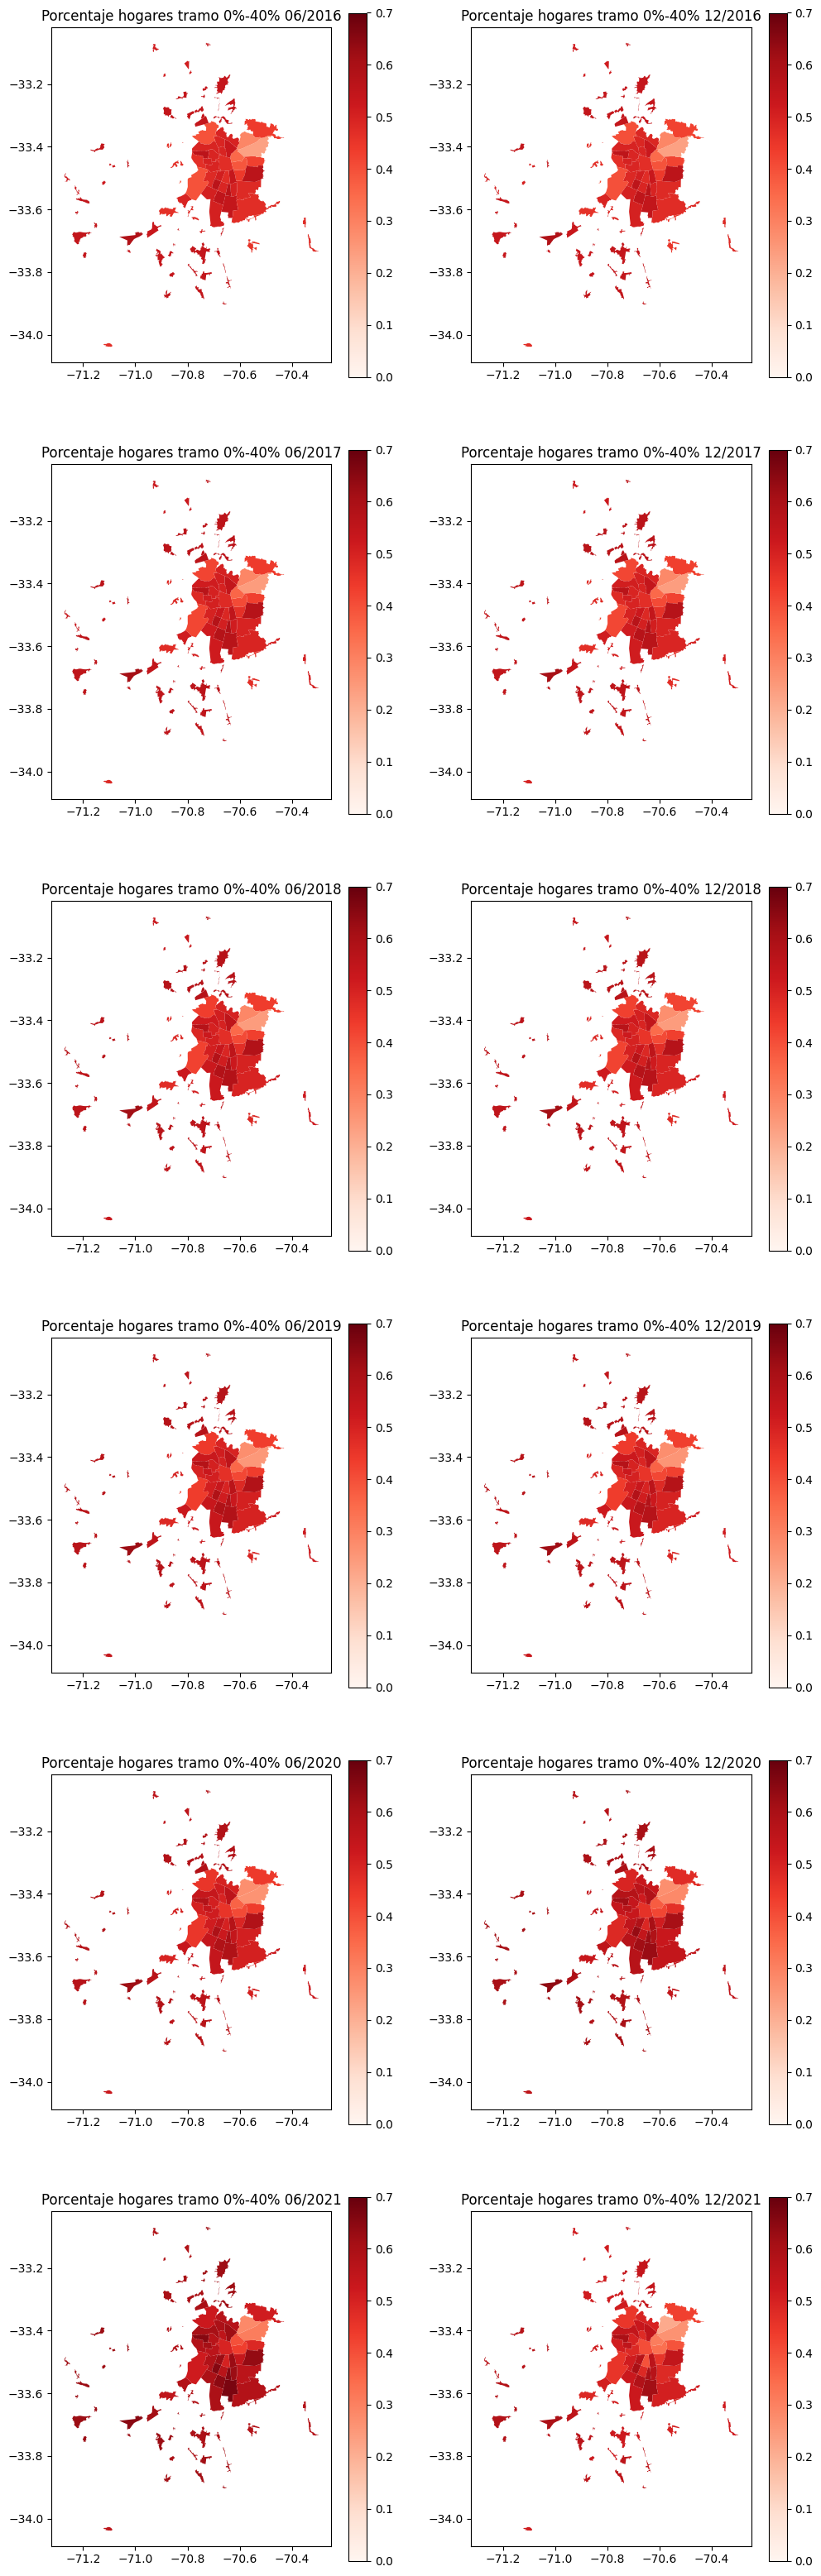

In [ ]:
# graficamos porcentaje de hogares en tramo bajo
fig, axes = plt.subplots(6, 2)
fig.set_size_inches(12, 40)

i, j = 0, 0
for periodo in lista_periodos:
    plot_mapa(dict_mapas=dict_mapas, periodo=periodo, tramos="bajos", ax=axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

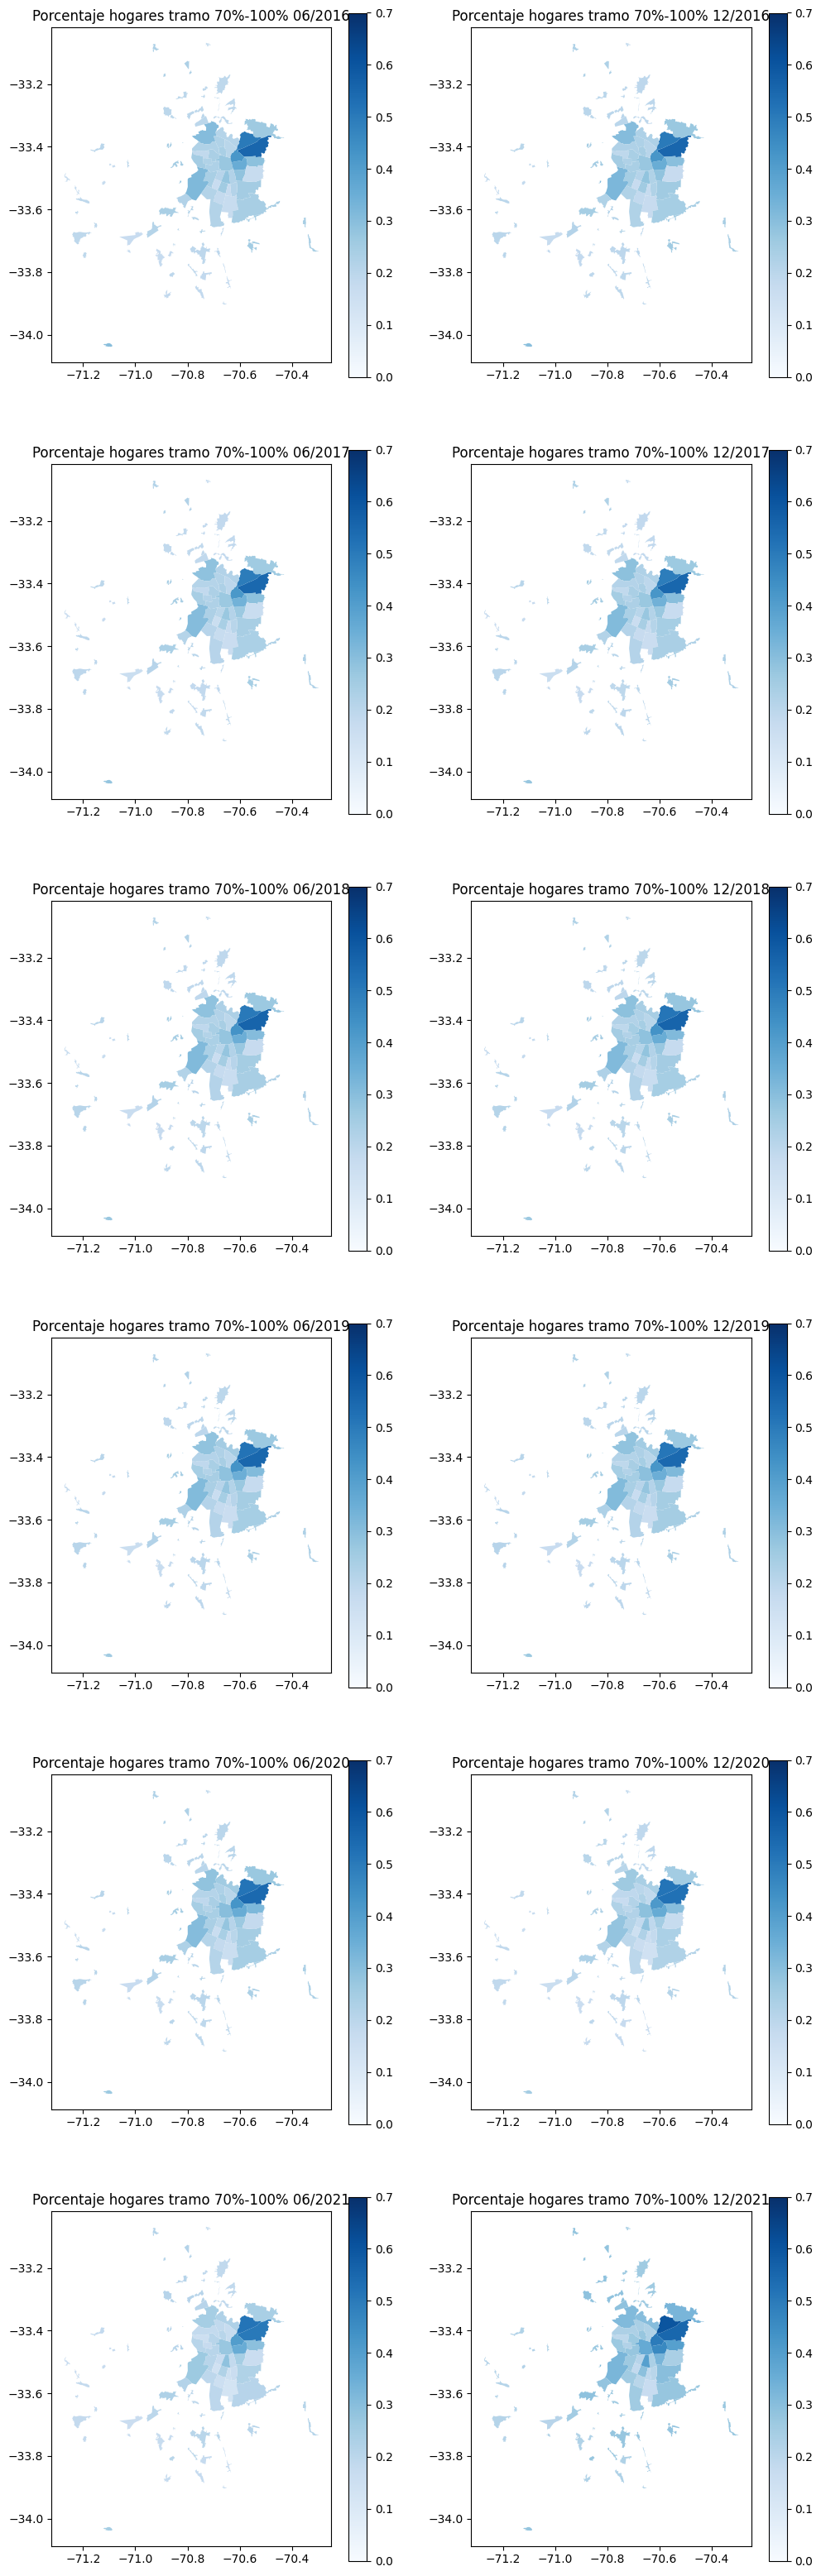

In [ ]:
# graficamos porcentaje de hogares en tramo alto
fig, axes = plt.subplots(6, 2)
fig.set_size_inches(12, 40)

i, j = 0, 0
for periodo in lista_periodos:
    plot_mapa(dict_mapas=dict_mapas, periodo=periodo, tramos="altos", ax=axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

In [41]:
# Nuevo dict de mapas que considera solo la provincia de santiago (de código 131)
dict_mapas_santiago = {}
for periodo, mapa in dict_mapas.items():
    mapa_santiago = mapa[mapa["codigo_provincia"] == 131]
    dict_mapas_santiago[periodo] = mapa_santiago

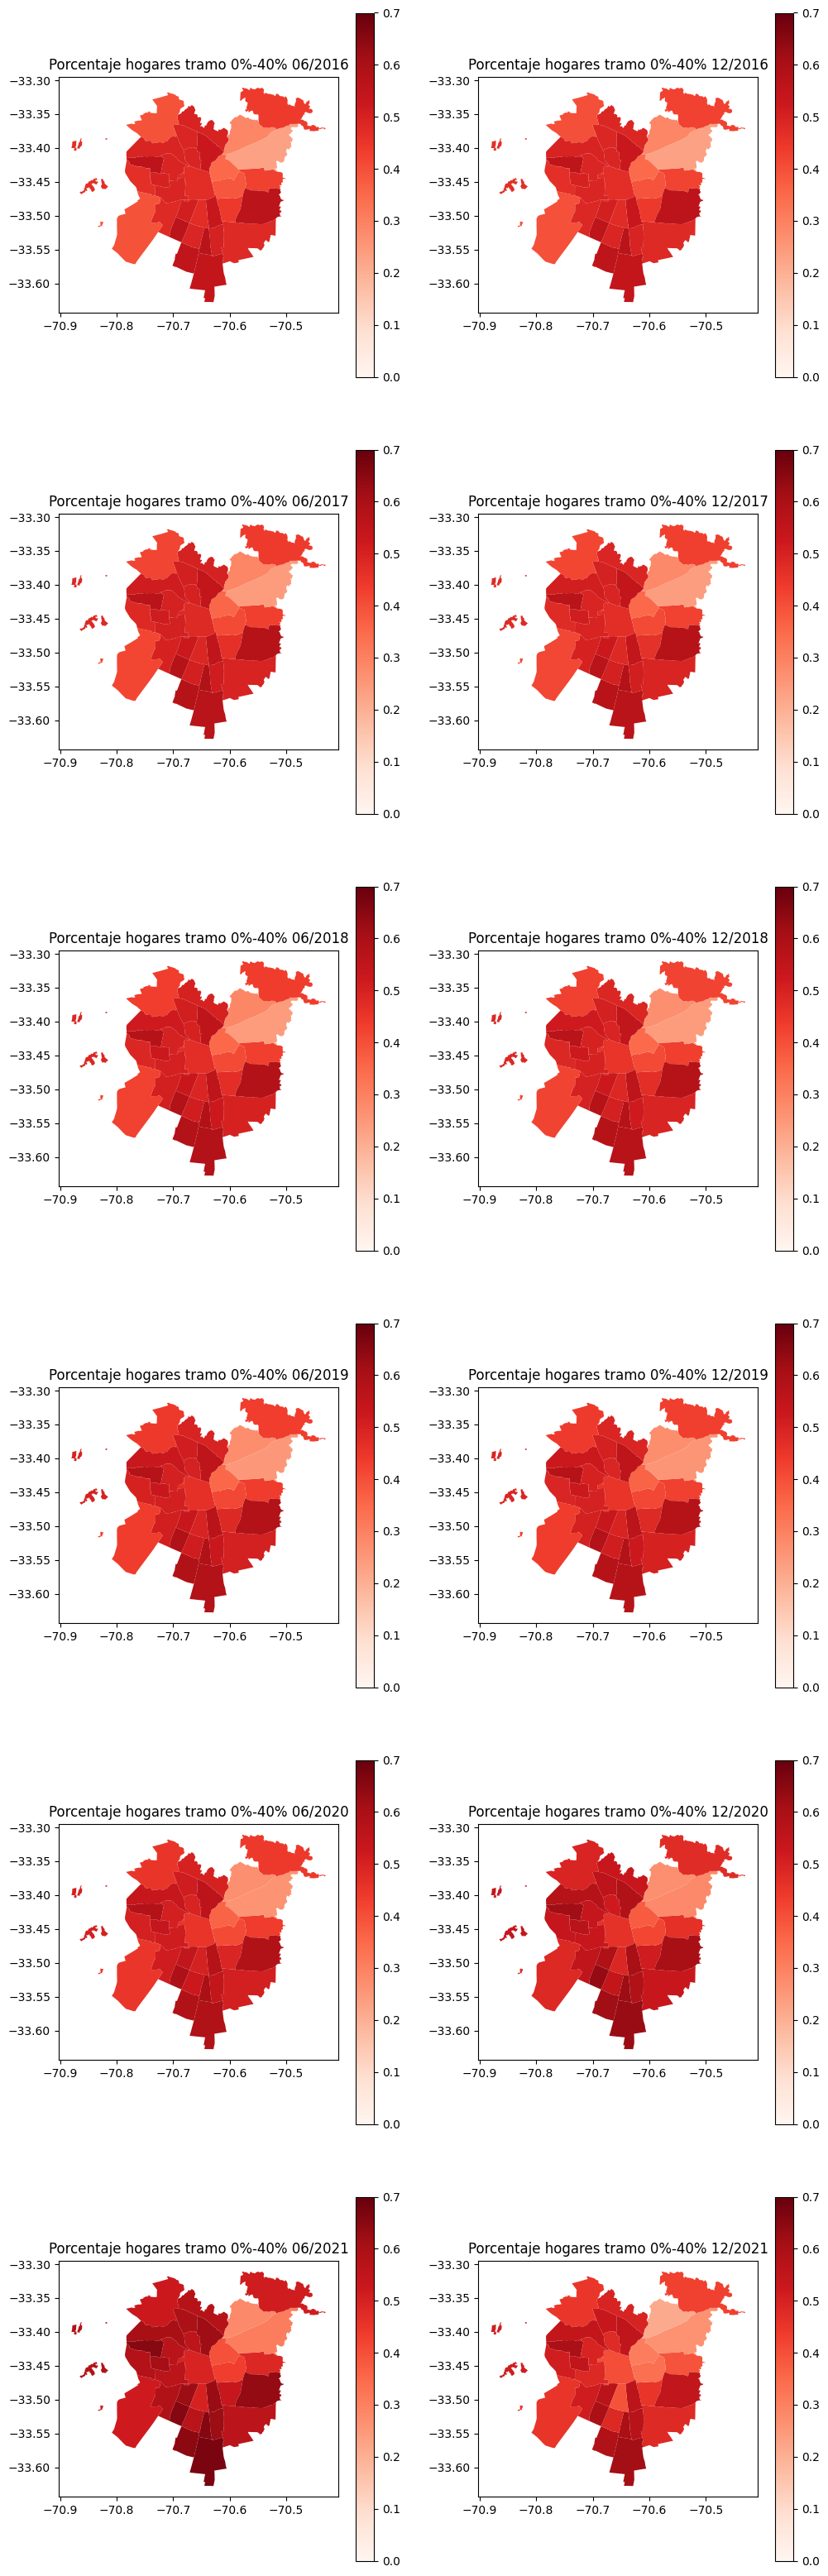

In [44]:
# Graficamos porcentaje de hogares en tramo bajo solo en provincia de santiago

fig, axes = plt.subplots(6, 2)
fig.set_size_inches(12, 40)

i, j = 0, 0
for periodo in lista_periodos:
    plot_mapa(dict_mapas=dict_mapas_santiago, periodo=periodo, tramos="bajos", ax=axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

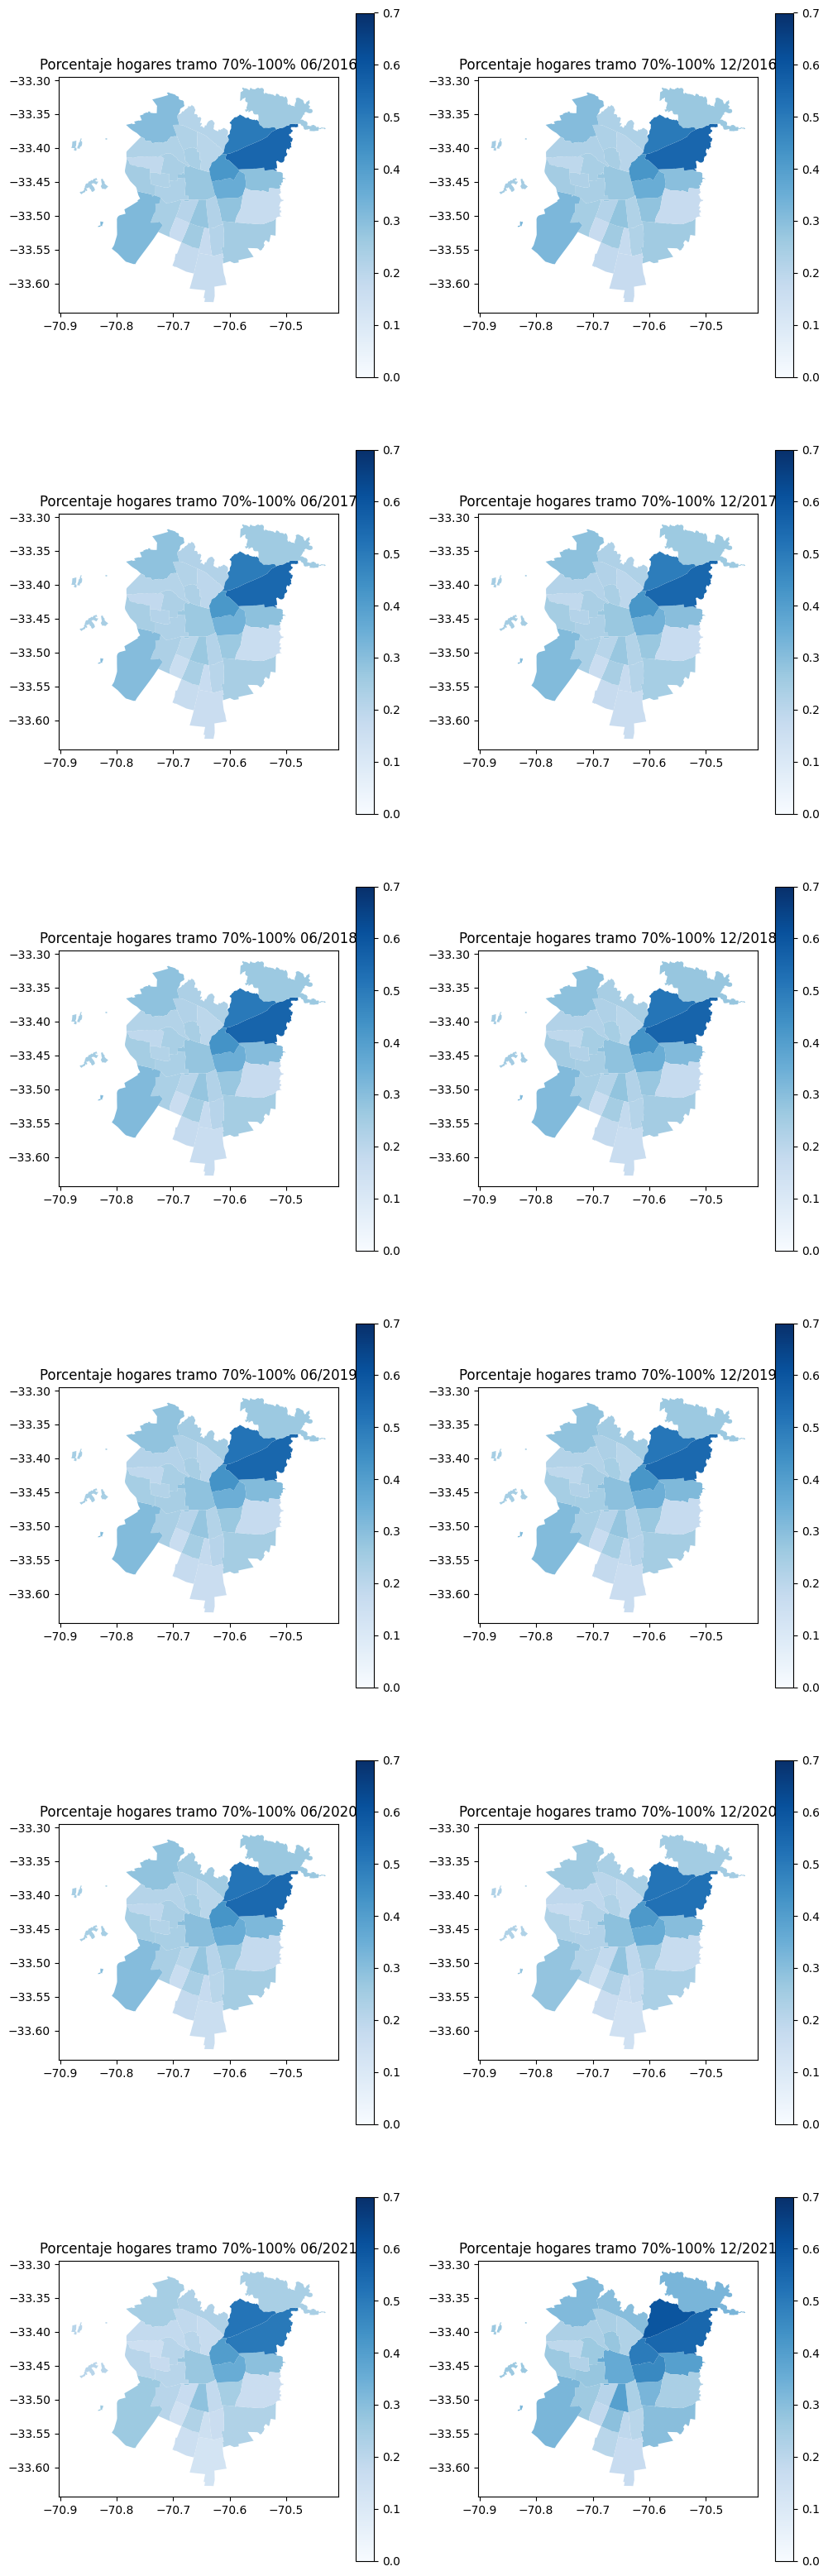

In [45]:
# Graficamos porcentaje de hogares en tramo alto solo en provincia de santiago

fig, axes = plt.subplots(6, 2)
fig.set_size_inches(12, 40)

i, j = 0, 0
for periodo in lista_periodos:
    plot_mapa(dict_mapas=dict_mapas_santiago, periodo=periodo, tramos="altos", ax=axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

## Regresiones lineales de tramos CSE

In [47]:
# lista con nombres de todas las comunas en la RM
lista_comunas = list(dict_mapas["201606"]["nombre comuna"])
# lista con periodos disponibles en la data
lista_periodos = list(dict_mapas.keys())
lista_periodos.sort()

In [48]:
# funcion que retorna un df con la info de porcentajes tramo bajo/alto de una comuna
# a lo largo del tiempo

def df_comuna(nombre_comuna, tramos):
    if tramos == "bajos":
        columna_clave = "prc tramo 0 - 40"
    elif tramos == "altos":
        columna_clave = "prc tramos altos"
    df = pd.DataFrame({"year": [], columna_clave: []})
    for periodo in lista_periodos:
        ano = float(periodo[0:4]) + float(periodo[4:]) / 12
        com = dict_mapas[periodo][dict_mapas[periodo]["nombre comuna"] == nombre_comuna]
        df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
        df = pd.concat((df, df_provisorio), axis="index", ignore_index=True)
    return df

In [49]:
# funcion que retorna el ajuste lineal de la data de los porcentajes tramo bajo/alto de
# una comuna a lo largo del tiempo

def linear_comuna(nombre_comuna, tramos):
    if tramos == "bajos":
        columna_clave = "prc tramo 0 - 40"
    elif tramos == "altos":
        columna_clave = "prc tramos altos"
    df_com = df_comuna(nombre_comuna, tramos)
    y = df_com[columna_clave]
    x = df_com["year"]
    x = sm.add_constant(x)
    return sm.OLS(y, x).fit()

In [59]:
# funcion que hace grafica la data de los porcentajes de tramos bajo/alto de una
# comuna a lo largo del tiempo, junto con la recta del ajuste lineal

def plot_comuna(nombre_comuna, tramos, ax):
    if tramos == "bajos":
        columna_clave = "prc tramo 0 - 40"
        eje_y = "Porcentaje hogares tramo 0%-40%"
    elif tramos == "altos":
        columna_clave = "prc tramos altos"
        eje_y = "Porcentaje hogares tramo 70%-100%"
    df_com = df_comuna(nombre_comuna, tramos)
    linear_com = linear_comuna(nombre_comuna, tramos)
    beta_0, beta_1 = linear_com.params
    x_ticks = np.arange(start=2015, stop=2025, step=0.5)
    y_ticks = beta_0 + beta_1 * x_ticks
    ax.set_title(nombre_comuna)
    sns.scatterplot(
        df_com,
        x = "year",
        y = columna_clave,
        label = "Datos Reales",
        color = "black",
        ax=ax
    )
    sns.lineplot(
        x = x_ticks,
        y = y_ticks, 
        label = "Ajuste Lineal",
        color = "red",
        ax=ax
    )
    ax.set_ylabel(eje_y)
    ax.set_xlabel("Año")
    ax.legend()

/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn

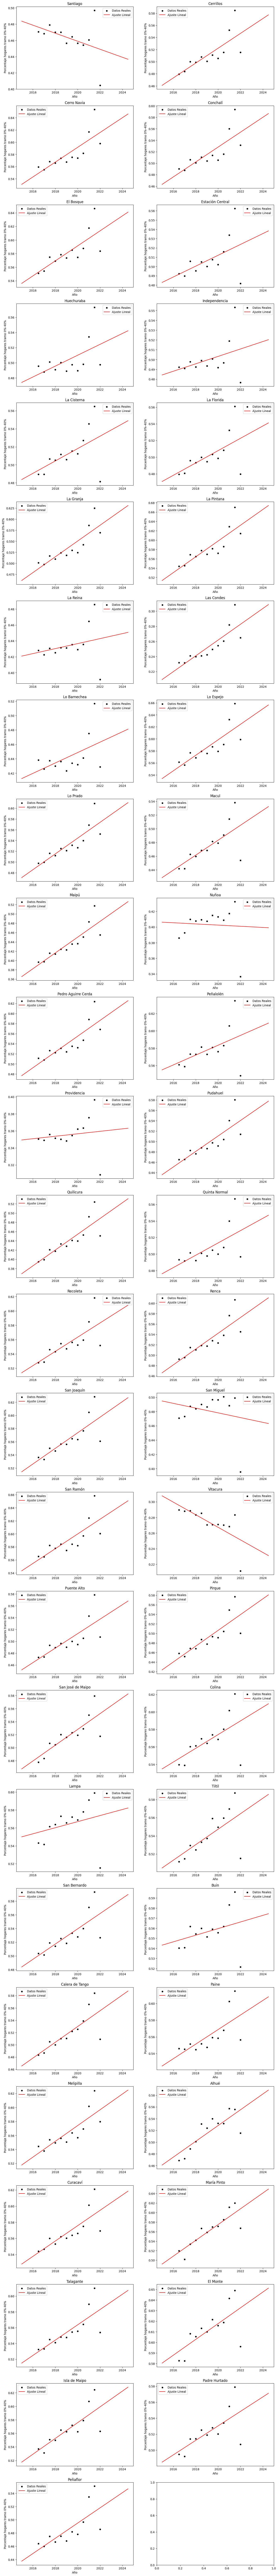

In [ ]:
# Graficamos para el tramo bajo

fig, axes = plt.subplots(26, 2)
fig.set_size_inches(16, 160)

i, j = 0, 0
for comuna in lista_comunas:
    plot_comuna(comuna, "bajos", axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn/T/ipykernel_61226/3458453290.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df_provisorio = pd.DataFrame({"year": [ano], columna_clave: [float(com[columna_clave])]})
/var/folders/ym/46w6_4ls407_ndr7k1j2qkgw0000gn

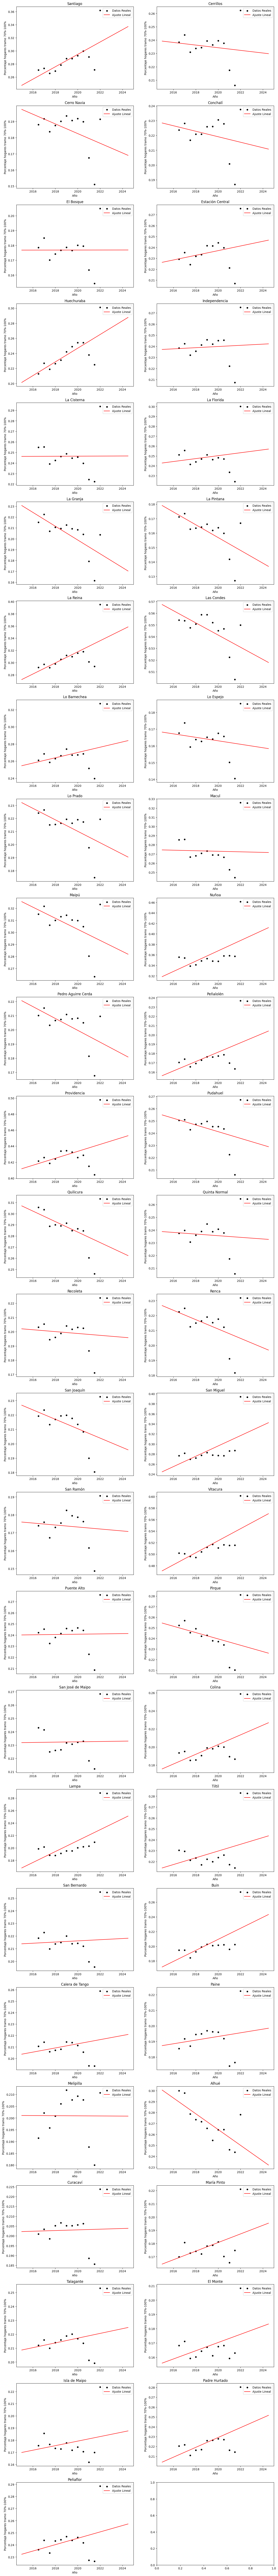

In [62]:
# Graficamos para el tramo alto

fig, axes = plt.subplots(26, 2)
fig.set_size_inches(16, 160)

i, j = 0, 0
for comuna in lista_comunas:
    plot_comuna(comuna, "altos", axes[i][j])
    if j == 0:
        j += 1
    else:
        j = 0
        i += 1

In [ ]:
# Comparar parámetros b_1 de cada comuna